# Latincom 2025 - Anomaly Detection in Industrial IoT (IIoT)

Dataset: https://ieee-dataport.org/documents/bruriiot-dataset-network-anomaly-detection-iiot-enhanced-feature-engineering-approach



Tasks:
- balancear
- tempos OK
- confusion matrix OK
- testar com um tipo de ataque (mirai)
- testar retirando o ip
- tcp e udp

In [1]:
# install dependencies
!pip install xgboost pyimpetus Boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.1 MB/s eta 0:00:00


## Downloading dataset

In [2]:
# download BRUIIoT.csv from drive
!gdown --id 18jejnWLvTJkUnzCGDsU9xaeNIDS2i0G1

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=18jejnWLvTJkUnzCGDsU9xaeNIDS2i0G1
From (redirected): https://drive.google.com/uc?id=18jejnWLvTJkUnzCGDsU9xaeNIDS2i0G1&confirm=t&uuid=1b9e5204-2207-4a6d-be6b-b967db715b38
To: /content/BRUIIoT.csv
100% 3.00G/3.00G [00:41<00:00, 71.8MB/s]


In [3]:
# download BRUIIoT_test.csv from drive
!gdown --id 1TCesDO93j-Ob4B08b03GWEPAqcr20O81

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TCesDO93j-Ob4B08b03GWEPAqcr20O81
From (redirected): https://drive.google.com/uc?id=1TCesDO93j-Ob4B08b03GWEPAqcr20O81&confirm=t&uuid=8e0b7a45-0e22-471e-97a8-73e79b6132b1
To: /content/BRUIIoT_test.csv
100% 604M/604M [00:07<00:00, 81.1MB/s]


In [4]:
# download BRUIIoT_train.csv from drive
!gdown --id 1r1fPPZQRoOT7Be7nG0xvaWaZuTuj-pE8

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1r1fPPZQRoOT7Be7nG0xvaWaZuTuj-pE8
From (redirected): https://drive.google.com/uc?id=1r1fPPZQRoOT7Be7nG0xvaWaZuTuj-pE8&confirm=t&uuid=729b6974-f6d1-494d-9fd7-b942ab571e7a
To: /content/BRUIIoT_train.csv
100% 2.41G/2.41G [00:27<00:00, 89.3MB/s]


## 1. Import libraries

In [1]:
import dask.dataframe as dd
import polars as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from xgboost import XGBClassifier
from boruta import BorutaPy
from PyImpetus import PPIMBC

import time
from tqdm.notebook import tqdm

%matplotlib inline

SEED = 2025

## 2. Loading dataset

In [2]:
# load dataset with Polars
df = pl.read_csv('BRUIIoT.csv')
print(df.shape)

(2776422, 267)


In [3]:
total_rows = df.shape[0]
print(f'There are {total_rows} total observations.')

There are 2776422 total observations.


In [4]:
# add index column
df = df.with_columns(pl.Series("index", list(range(total_rows))))
print(df.shape)
df.head()

(2776422, 268)


frame.time__calculate_duration,ip.src_host__nunique,ip.dst_host__nunique,arp.dst.proto_ipv4__nunique,arp.opcode__min,arp.opcode__max,arp.opcode__sum,arp.opcode__mean,arp.opcode__min_max_diff,arp.opcode__min_max_ratio,arp.opcode__min_max_product,arp.opcode__mean_square,arp.hw.size__min,arp.hw.size__max,arp.hw.size__sum,arp.hw.size__mean,arp.hw.size__min_max_diff,arp.hw.size__min_max_ratio,arp.hw.size__min_max_product,arp.hw.size__mean_square,arp.src.proto_ipv4__nunique,icmp.checksum__min,icmp.checksum__max,icmp.checksum__sum,icmp.checksum__mean,icmp.checksum__min_max_diff,icmp.checksum__min_max_ratio,icmp.checksum__min_max_product,icmp.checksum__mean_square,icmp.seq_le__min,icmp.seq_le__max,icmp.seq_le__sum,icmp.seq_le__mean,icmp.seq_le__min_max_diff,icmp.seq_le__min_max_ratio,icmp.seq_le__min_max_product,icmp.seq_le__mean_square,…,mqtt.hdrflags__nunique,mqtt.hdrflags__min_max_diff,mqtt.hdrflags__min_max_ratio,mqtt.hdrflags__min_max_product,mqtt.hdrflags__mean_square,mqtt.len__min,mqtt.len__max,mqtt.len__sum,mqtt.len__mean,mqtt.len__min_max_diff,mqtt.len__min_max_ratio,mqtt.len__min_max_product,mqtt.len__mean_square,mqtt.msg__nunique,mqtt.msgtype__nunique,mqtt.proto_len__min,mqtt.proto_len__max,mqtt.proto_len__sum,mqtt.proto_len__mean,mqtt.proto_len__min_max_diff,mqtt.proto_len__min_max_ratio,mqtt.proto_len__min_max_product,mqtt.proto_len__mean_square,mqtt.protoname__nunique,mqtt.topic__nunique,mqtt.topic_len__min,mqtt.topic_len__max,mqtt.topic_len__sum,mqtt.topic_len__mean,mqtt.topic_len__min_max_diff,mqtt.topic_len__min_max_ratio,mqtt.topic_len__min_max_product,mqtt.topic_len__mean_square,is_attack__most_frequent,attack_label_enc__most_frequent,attack_label__most_frequent,index
f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,i64
0.000174,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5356,63724,508734,25436.7,58368,11.895464,341305744,6.4703e8,39914.0,60551.0,1.15866e6,57933.0,20637.0,1.516999,2.4168e9,3.3562e9,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,"""ddos_smurf""",0
0.010008,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,14969,56911,662791,33139.55,41942,3.80167,851900759,1.0982e9,5285.0,40925.0,393236.0,19661.8,35640.0,7.742149,2.16288625e8,3.8659e8,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,"""ddos_smurf""",1
0.001801,13,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,31752,75228,3761.4,31752,31752.0,0,1.4148e7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,"""ddos_syn_flood""",2
0.002471,1,20,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,479,65241,790546,39527.3,64762,135.91875,31250439,1.5624e9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,"""ddos_syn_flood""",3
0.00535,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,"""ddos_http_flood""",4


### Data splits

In [5]:
# get 20% random sample for test set
df_test = df.sample(n=int(total_rows*0.2), seed=SEED)
df_test.shape

(555284, 268)

In [ ]:
# use the remaining (80%) for training
"""Google Colab may not have enough RAM memory"""
df_train = df.join(df_test, on=['index'], how='anti')

In [ ]:
# save splits to disk
df_test.write_csv('BRUIIoT_test.csv')
df_train.write_csv('BRUIIoT_train.csv')

In [2]:
# restore splits
df_test = pd.read_csv('BRUIIoT_test.csv')
df_train = pl.read_csv('BRUIIoT_train.csv')

### Sampling training data

In [3]:
df_train = df_train.sample(n=int(df_train.shape[0]*0.01), seed=SEED).to_pandas()
print(df_train.shape)
df_train.head()

(22211, 268)


,frame.time__calculate_duration,ip.src_host__nunique,ip.dst_host__nunique,arp.dst.proto_ipv4__nunique,arp.opcode__min,arp.opcode__max,arp.opcode__sum,arp.opcode__mean,arp.opcode__min_max_diff,arp.opcode__min_max_ratio,...,mqtt.topic_len__sum,mqtt.topic_len__mean,mqtt.topic_len__min_max_diff,mqtt.topic_len__min_max_ratio,mqtt.topic_len__min_max_product,mqtt.topic_len__mean_square,is_attack__most_frequent,attack_label_enc__most_frequent,attack_label__most_frequent,index
0,0.011397,14,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,5,ddos_syn_flood,453731
1,0.000062,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,4,ddos_smurf,1078187
2,0.000353,19,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,5,ddos_syn_flood,1050197
3,0.000141,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,4,ddos_smurf,350005
4,0.001327,13,9,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,5,ddos_syn_flood,1265194


In [4]:
# label columns
targets_cols = ['attack_label__most_frequent', 'attack_label_enc__most_frequent', 'is_attack__most_frequent']

In [5]:
# get protocols
modules = list(set(map(lambda x: x.split('.')[0], df_train.columns)))  # get protocols from columns
modules = [m for m in modules if m not in targets_cols]  # remove target columns
modules.remove('frame')
modules.remove('index')
modules

['icmp', 'udp', 'dns', 'ip', 'mqtt', 'arp', 'http', 'tcp']

Text(0.5, 1.0, 'Attack types distribution - test')

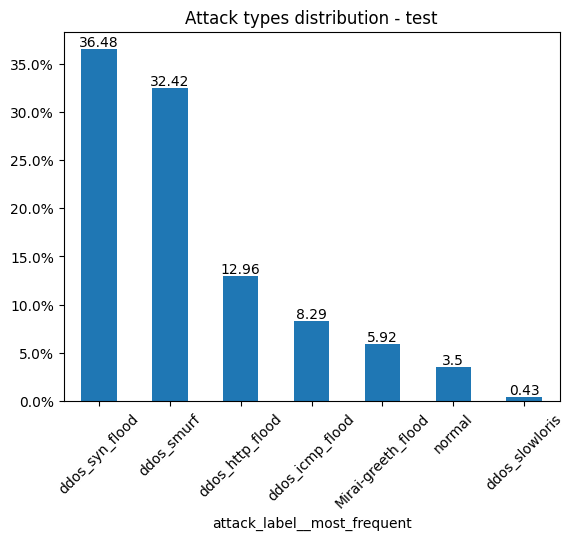

In [6]:
ax = df_test['attack_label__most_frequent'].value_counts(normalize=True).apply(lambda x: round(x*100, 2)).plot.bar(rot=45)

# add bar's labels
for container in ax.containers:
    ax.bar_label(container)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Attack types distribution - test')

Text(0.5, 1.0, 'Attack types distribution - training')

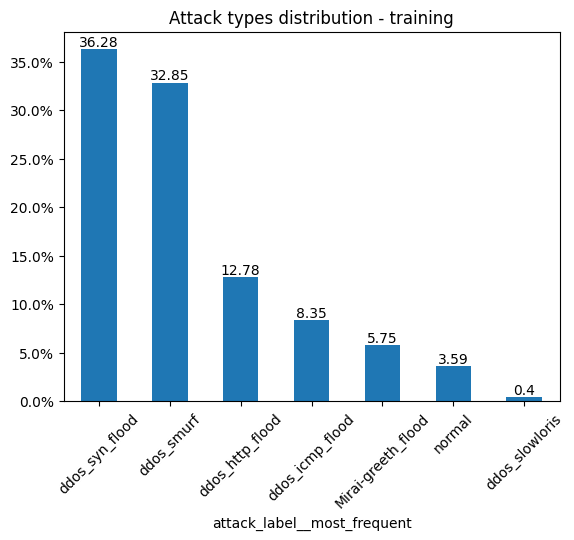

In [7]:
ax = df_train['attack_label__most_frequent'].value_counts(normalize=True).apply(lambda x: round(x*100, 2)).plot.bar(rot=45)

# add bar's labels
for container in ax.containers:
    ax.bar_label(container)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Attack types distribution - training')

In [8]:
df_train.isnull().sum()

,0
frame.time__calculate_duration,0
ip.src_host__nunique,0
ip.dst_host__nunique,0
arp.dst.proto_ipv4__nunique,0
arp.opcode__min,0
...,...
mqtt.topic_len__mean_square,0
is_attack__most_frequent,0
attack_label_enc__most_frequent,0
attack_label__most_frequent,0


In [9]:
def filter_module(columns, module):
    match_module = map(lambda x: x if module+'.' in x else None, columns)  # match module columns else None
    clean_module = filter(lambda x: x is not None, match_module)  # remove None values
    return list(clean_module)

### Data splits

In [10]:
# map label indices
labels = list(set(zip(df_train['attack_label_enc__most_frequent'], df_train['attack_label__most_frequent'])))  # get encoding and label pairs
labels = {x[0]: x[1] for x in labels}  # to dict
labels = dict(sorted(labels.items()))  # order by key (enconding)
labels

{0: 'Mirai-greeth_flood',
 1: 'ddos_http_flood',
 2: 'ddos_icmp_flood',
 3: 'ddos_slowloris',
 4: 'ddos_smurf',
 5: 'ddos_syn_flood',
 6: 'normal'}

In [11]:
# get features and targets
X_train = df_train.drop(columns=targets_cols+['index'])
y_train = df_train.loc[:, 'attack_label_enc__most_frequent']

X_test = df_test.drop(columns=targets_cols+['index'])
y_test = df_test.loc[:, 'attack_label_enc__most_frequent']

# # data splits
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

print('Training features size:', X_train.shape)
print('Test features size:', X_test.shape)
print('Training labels size:', y_train.shape)
print('Test labels size:', y_test.shape)

Training features size: (22211, 264)
Test features size: (555284, 264)
Training labels size: (22211,)
Test labels size: (555284,)


In [13]:
def calculate_inference_time(predictor, X_test, num_exec=100):
    times = []
    print('Doing inference test...')
    for _ in tqdm(range(num_exec)):
        tic = time.time()
        predictor.predict(X_test)
        tac = time.time()

        inference_time = tac-tic
        times.append(inference_time)

    return pd.Series(times)


def train_xgboost(X_train, y_train, X_test, y_test, method_name=None):
    # clf = XGBClassifier(n_estimators=1000, max_depth=8, learning_rate=0.01, random_state=SEED)
    clf = XGBClassifier(random_state=SEED)
    clf.fit(X_train, y_train)

    # inference test
    times = calculate_inference_time(clf, X_test, num_exec=5)
    print(f'Test inference time for {X_test.shape[0]} samples in seconds:')
    print(times.describe())

    # predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)

    # generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.values()))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f'Confusion matrix: {method_name}')
    plt.show()

    # metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

    print('Test accuracy:', acc)
    print('Test precision:', precision)
    print('Test recall:', recall)
    print('Test f1-score:', f1)
    print('Test ROC-AUC:', roc_auc)

## 3. Training with all features

Doing inference test...


  0%|          | 0/5 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count     5.000000
mean     10.188755
std       0.108030
min      10.100186
25%      10.110362
50%      10.166612
75%      10.198685
max      10.367929
dtype: float64


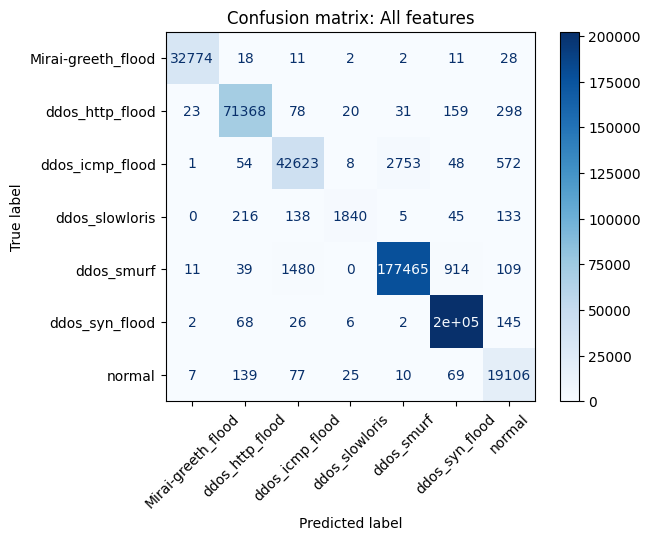

Test accuracy: 0.985983748856441
Test precision: 0.9762458355614388
Test recall: 0.950941969313793
Test f1-score: 0.9619296158846548
Test ROC-AUC: 0.9991856272793225


In [14]:
train_xgboost(X_train, y_train, X_test, y_test, method_name='All features')

Best model (XGBoost) from authors:
- accuracy of 99.52%
- precision of 98.20%
- recall of 98.13%
- F1-score of 98.17%

## 4. Training with random features

TODO: see p-value...

In [15]:
random_cols = X_train.sample(16, axis=1, random_state=SEED).columns
random_cols

Index(['http.response__min_max_product', 'tcp.options__nunique',
       'icmp.seq_le__sum', 'arp.hw.size__sum', 'icmp.checksum__min_max_ratio',
       'http.request.version__nunique', 'dns.retransmit_request__mean_square',
       'udp.time_delta__mean', 'mqtt.conflags__min_max_ratio',
       'tcp.checksum__min_max_product', 'tcp.flags__mean_square',
       'http.response__mean_square', 'tcp.len__min_max_ratio',
       'icmp.seq_le__max', 'arp.hw.size__min_max_ratio', 'dns.qry.qu__sum'],
      dtype='object')

Doing inference test...


  0%|          | 0/5 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count     5.000000
mean     10.871308
std       4.198990
min       6.437928
25%       7.811259
50%      10.541581
75%      12.459342
max      17.106428
dtype: float64


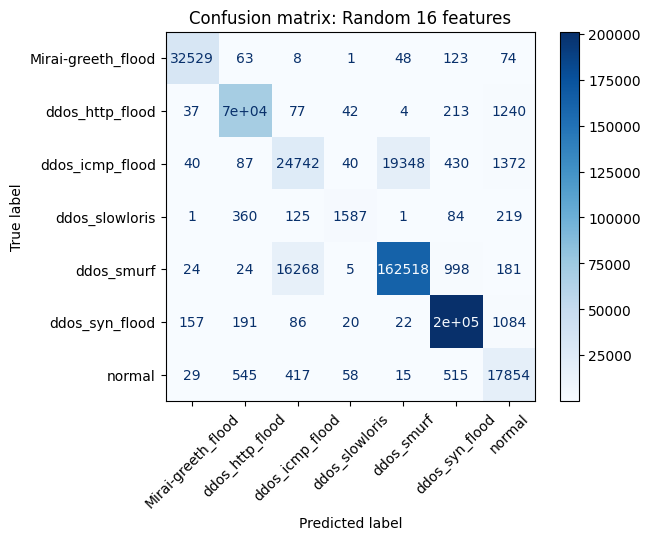

Test accuracy: 0.9195438730451445
Test precision: 0.8805743931887117
Test recall: 0.8552287007170422
Test f1-score: 0.8646521921526803
Test ROC-AUC: 0.9897876606913892


In [16]:
train_xgboost(X_train.loc[:, random_cols], y_train, X_test.loc[:, random_cols], y_test, method_name='Random 16 features')

## 5. Feature selection

In [17]:
for m in modules:
    print(f'**Processing module {m}...**')

    # get module's columns
    cols = filter_module(df_train.columns, m)
    print(f'Columns length: {len(cols)}, columns:', cols)
    print('')

**Processing module icmp...**
Columns length: 16, columns: ['icmp.checksum__min', 'icmp.checksum__max', 'icmp.checksum__sum', 'icmp.checksum__mean', 'icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio', 'icmp.checksum__min_max_product', 'icmp.checksum__mean_square', 'icmp.seq_le__min', 'icmp.seq_le__max', 'icmp.seq_le__sum', 'icmp.seq_le__mean', 'icmp.seq_le__min_max_diff', 'icmp.seq_le__min_max_ratio', 'icmp.seq_le__min_max_product', 'icmp.seq_le__mean_square']

**Processing module udp...**
Columns length: 11, columns: ['udp.port__nunique', 'udp.stream__nunique', 'udp.time_delta__min', 'udp.time_delta__max', 'udp.time_delta__sum', 'udp.time_delta__mean', 'udp.time_delta__calculate_duration', 'udp.time_delta__min_max_diff', 'udp.time_delta__min_max_ratio', 'udp.time_delta__min_max_product', 'udp.time_delta__mean_square']

**Processing module dns...**
Columns length: 42, columns: ['dns.qry.name__nunique', 'dns.qry.name.len__nunique', 'dns.qry.qu__min', 'dns.qry.qu__max', 'dns.q

### 5.1 Mutual Information (MI)

In [19]:
def fs_mutual_information(X_train, y_train):
    # mutual information
    mi_measures = mutual_info_classif(X_train, y_train, random_state=SEED)

    # plot mutual information distribution
    sns.histplot(mi_measures)
    plt.show()

    # determine threshold
    third_quartile = np.quantile(mi_measures, 0.75)

    # select features
    mask = (mi_measures > third_quartile)[:, None]
    col_idx = np.where(np.any(mask, axis=1))[0]

    selected_features = X_train.iloc[:, col_idx].columns
    return selected_features

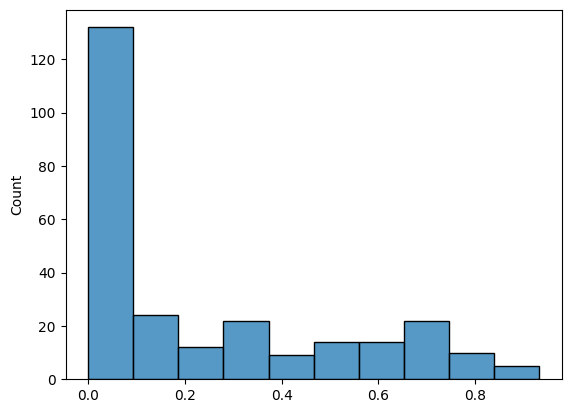

CPU times: user 37.4 s, sys: 339 ms, total: 37.7 s
Wall time: 42.4 s


(66,
 Index(['ip.src_host__nunique', 'ip.dst_host__nunique', 'icmp.checksum__min',
        'icmp.checksum__max', 'icmp.checksum__sum', 'icmp.checksum__mean',
        'icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio',
        'icmp.checksum__min_max_product', 'icmp.checksum__mean_square',
        'icmp.seq_le__min', 'icmp.seq_le__max', 'icmp.seq_le__sum',
        'icmp.seq_le__mean', 'icmp.seq_le__min_max_diff',
        'icmp.seq_le__min_max_ratio', 'icmp.seq_le__min_max_product',
        'icmp.seq_le__mean_square', 'tcp.ack__max', 'tcp.ack__sum',
        'tcp.ack__mean', 'tcp.ack__min_max_diff', 'tcp.ack__min_max_ratio',
        'tcp.ack_raw__max', 'tcp.ack_raw__sum', 'tcp.ack_raw__mean',
        'tcp.ack_raw__min_max_diff', 'tcp.ack_raw__min_max_ratio',
        'tcp.ack_raw__mean_square', 'tcp.checksum__max', 'tcp.checksum__sum',
        'tcp.checksum__mean', 'tcp.checksum__min_max_diff',
        'tcp.checksum__min_max_ratio', 'tcp.checksum__min_max_product',
        'tcp.

In [20]:
%%time
mi_features = fs_mutual_information(X_train, y_train)
len(mi_features), mi_features

Doing inference test...


  0%|          | 0/5 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    5.000000
mean     8.425260
std      0.914348
min      7.122590
25%      8.145555
50%      8.285289
75%      9.104607
max      9.468257
dtype: float64


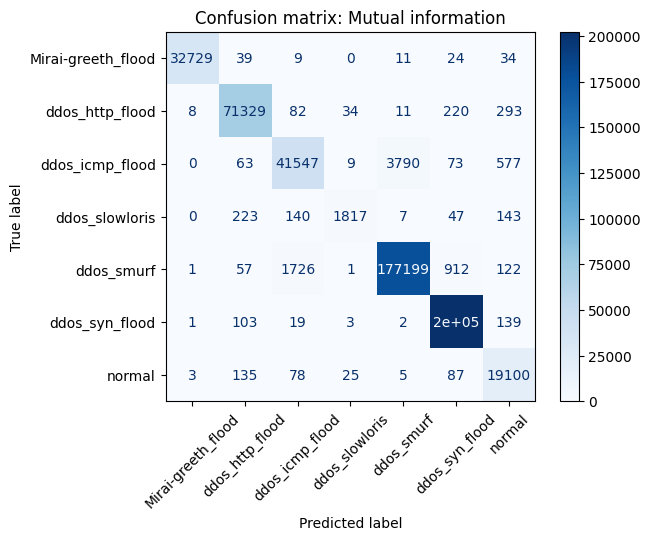

Test accuracy: 0.9833310522183243
Test precision: 0.9734059160020505
Test recall: 0.9456813246956043
Test f1-score: 0.9577459123377708
Test ROC-AUC: 0.9988749513516363


In [21]:
train_xgboost(X_train.loc[:, mi_features], y_train, X_test.loc[:, mi_features], y_test, method_name='Mutual information')

### 5.2 Causality Markov Blanket

In [26]:
def fs_causal_markov_blanket(X_train, y_train, thresholds=[0.01, 0.001], val_size=0.2, verbose=0):
    predictor = RandomForestClassifier(n_jobs=-1)

    ### first, select features for each protocol ###
    selected_features = []
    for m in tqdm(modules):
        cols = filter_module(X_train.columns, m)
        X_train_protocol = X_train[cols].reset_index(drop=True)

        model = PPIMBC(
            model=predictor,
            p_val_thresh=thresholds[0],
            num_simul=5,
            simul_size=val_size,  # validation set size
            simul_type=0,
            sig_test_type='parametric',
            cv=0,
            n_jobs=-1,
            random_state=SEED,
            verbose=verbose,
        )
        model.fit_transform(X_train_protocol, y_train.values)
        selected_features.extend(model.MB)

    print('Intermediate number of selected features:', len(selected_features))
    print('Running final selection...')

    ### finally, select the features globally ###
    model = PPIMBC(
        model=predictor,
        p_val_thresh=thresholds[1],
        num_simul=5,
        simul_size=val_size,  # validation set size
        simul_type=0,
        sig_test_type='parametric',
        cv=0,
        n_jobs=-1,
        random_state=SEED,
        verbose=verbose,
    )
    model.fit_transform(X_train[selected_features].T.reset_index(drop=True).T, y_train.values)

    # select features
    selected_features = X_train[selected_features].iloc[:, model.MB].columns

    # plot mutual information distribution
    model.MB = selected_features
    model.feature_importance()
    plt.show()

    return selected_features

  0%|          | 0/8 [00:00<?, ?it/s]

Intermediate number of selected features: 31
Running final selection...


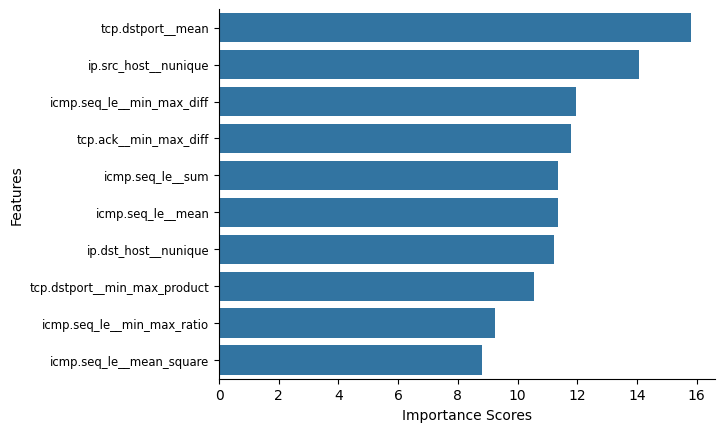

CPU times: user 32.9 s, sys: 6.43 s, total: 39.3 s
Wall time: 1h 4min 27s


(10,
 Index(['tcp.dstport__mean', 'ip.src_host__nunique',
        'icmp.seq_le__min_max_diff', 'tcp.ack__min_max_diff',
        'icmp.seq_le__sum', 'icmp.seq_le__mean', 'ip.dst_host__nunique',
        'tcp.dstport__min_max_product', 'icmp.seq_le__min_max_ratio',
        'icmp.seq_le__mean_square'],
       dtype='object'))

In [27]:
%%time
causal_selected_features = fs_causal_markov_blanket(X_train, y_train, thresholds=[0.01, 0.001], val_size=0.2)
len(causal_selected_features), causal_selected_features

Doing inference test...


  0%|          | 0/5 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count     5.000000
mean      8.723337
std       1.868626
min       6.695366
25%       7.029110
50%       8.728604
75%      10.386644
max      10.776959
dtype: float64


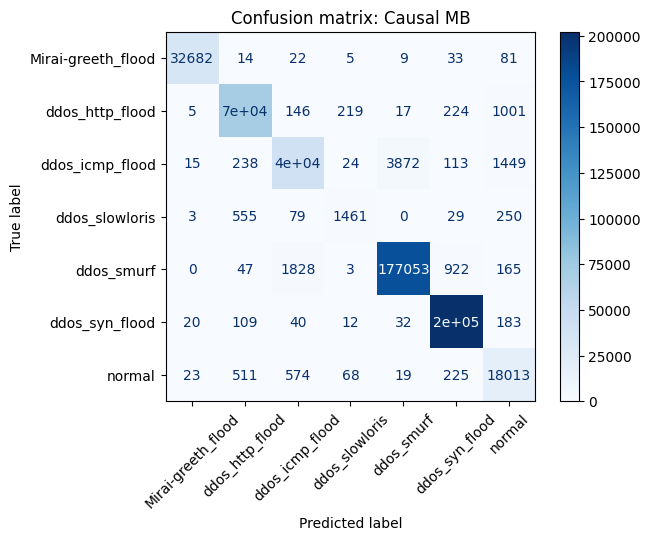

Test accuracy: 0.9762571945166798
Test precision: 0.9361243120447567
Test recall: 0.9102515896045291
Test f1-score: 0.9207997681436506
Test ROC-AUC: 0.9977595749566132


In [28]:
train_xgboost(X_train.loc[:, causal_selected_features], y_train, X_test.loc[:, causal_selected_features], y_test, method_name='Causal MB')

### 5.3 Recursive Feature Elimination (RFE)

In [37]:
def fs_rfe(X_train, y_train, n_features_to_select):
    # recursive feature elimination
    clf = RandomForestClassifier(n_jobs=-1)
    # clf = DecisionTreeClassifier()
    selector = RFE(clf, n_features_to_select=n_features_to_select, step=1)
    selector = selector.fit(X_train, y_train)

    # select features
    selected_features = X_train.iloc[:, selector.support_].columns
    return selected_features

In [38]:
%%time
rfe_selected_features = fs_rfe(X_train, y_train, n_features_to_select=4)
rfe_selected_features

CPU times: user 13min 22s, sys: 2.42 s, total: 13min 24s
Wall time: 13min 35s


Index(['ip.src_host__nunique', 'icmp.seq_le__min_max_diff',
       'tcp.dstport__min_max_product', 'tcp.options__nunique'],
      dtype='object')

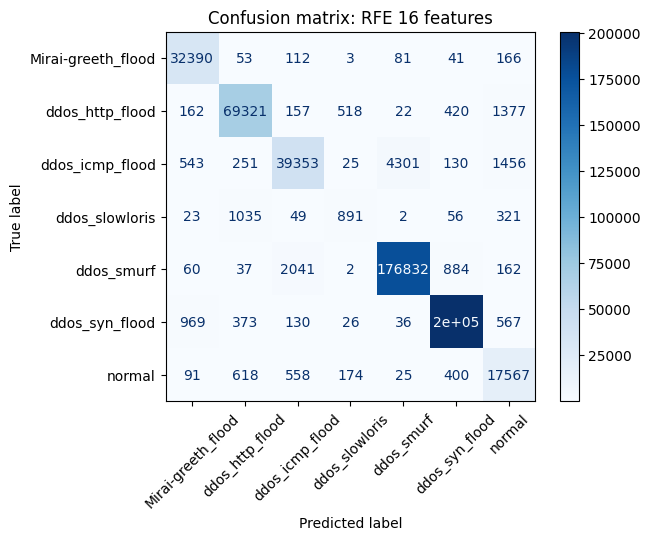

Test accuracy: 0.9667611528515139
Test precision: 0.8804676609123941
Test recall: 0.8649101067673739
Test f1-score: 0.869847046440651
Test ROC-AUC: 0.9958110572539143
Doing inference test...


  0%|          | 0/3 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    3.000000
mean     8.607743
std      1.153030
min      7.466805
25%      8.025367
50%      8.583929
75%      9.178212
max      9.772495
dtype: float64


In [39]:
train_xgboost(X_train.loc[:, rfe_selected_features], y_train, X_test.loc[:, rfe_selected_features], y_test, method_name='RFE 16 features')

### 5.4 Boruta

In [50]:
def fs_boruta(X_train, y_train, max_iter=30, n_estimators=100):
    # boruta
    clf = RandomForestClassifier(n_jobs=-1)
    # clf = DecisionTreeClassifier()
    boruta = BorutaPy(clf, max_iter=max_iter, n_estimators=n_estimators, random_state=SEED, verbose=2)
    boruta.fit_transform(X_train.values, y_train.values)

    # select features
    cols_selected = boruta.support_.tolist()
    selected_features = X_train.iloc[:, cols_selected].columns
    return selected_features

In [51]:
boruta_selected_features = fs_boruta(X_train, y_train, max_iter=15, n_estimators=100)
boruta_selected_features

Iteration: 	1 / 15
Confirmed: 	0
Tentative: 	264
Rejected: 	0
Iteration: 	2 / 15
Confirmed: 	0
Tentative: 	264
Rejected: 	0
Iteration: 	3 / 15
Confirmed: 	0
Tentative: 	264
Rejected: 	0
Iteration: 	4 / 15
Confirmed: 	0
Tentative: 	264
Rejected: 	0
Iteration: 	5 / 15
Confirmed: 	0
Tentative: 	264
Rejected: 	0
Iteration: 	6 / 15
Confirmed: 	0
Tentative: 	264
Rejected: 	0
Iteration: 	7 / 15
Confirmed: 	0
Tentative: 	264
Rejected: 	0
Iteration: 	8 / 15
Confirmed: 	76
Tentative: 	61
Rejected: 	127
Iteration: 	9 / 15
Confirmed: 	76
Tentative: 	61
Rejected: 	127
Iteration: 	10 / 15
Confirmed: 	76
Tentative: 	61
Rejected: 	127
Iteration: 	11 / 15
Confirmed: 	76
Tentative: 	61
Rejected: 	127
Iteration: 	12 / 15
Confirmed: 	83
Tentative: 	45
Rejected: 	136
Iteration: 	13 / 15
Confirmed: 	83
Tentative: 	45
Rejected: 	136
Iteration: 	14 / 15
Confirmed: 	83
Tentative: 	45
Rejected: 	136


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	83
Tentative: 	24
Rejected: 	157


Index(['frame.time__calculate_duration', 'ip.src_host__nunique',
       'ip.dst_host__nunique', 'icmp.checksum__min', 'icmp.checksum__max',
       'icmp.checksum__sum', 'icmp.checksum__mean',
       'icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio',
       'icmp.checksum__min_max_product', 'icmp.checksum__mean_square',
       'icmp.seq_le__min', 'icmp.seq_le__max', 'icmp.seq_le__sum',
       'icmp.seq_le__mean', 'icmp.seq_le__min_max_diff',
       'icmp.seq_le__min_max_ratio', 'icmp.seq_le__min_max_product',
       'icmp.seq_le__mean_square', 'http.content_length__max',
       'http.content_length__mean', 'http.content_length__min_max_ratio',
       'http.content_length__mean_square', 'http.request.method__nunique',
       'http.request.full_uri__nunique', 'http.request.version__nunique',
       'tcp.ack__max', 'tcp.ack__sum', 'tcp.ack__mean',
       'tcp.ack__min_max_diff', 'tcp.ack__min_max_ratio',
       'tcp.ack__mean_square', 'tcp.ack_raw__max', 'tcp.ack_raw__sum',
   

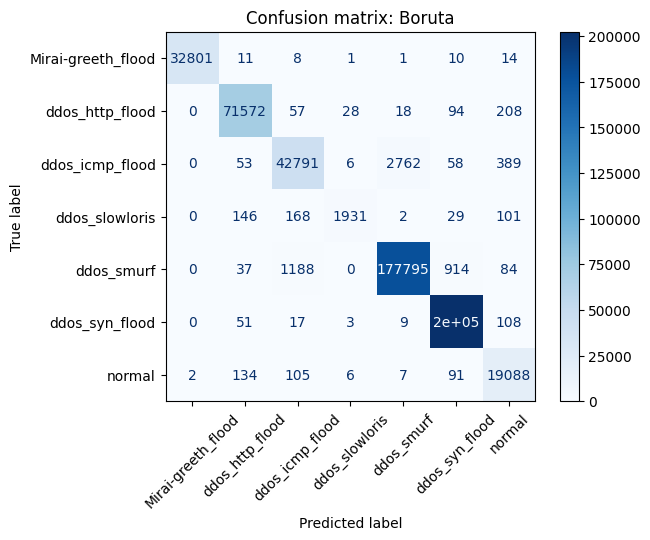

Test accuracy: 0.9875379085296893
Test precision: 0.9814664529569563
Test recall: 0.9576270147430195
Test f1-score: 0.9683773508539851
Test ROC-AUC: 0.9993960250413579
Doing inference test...


  0%|          | 0/3 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count     3.000000
mean      9.155638
std       1.551012
min       7.577695
25%       8.394339
50%       9.210983
75%       9.944610
max      10.678237
dtype: float64


In [52]:
train_xgboost(X_train.loc[:, boruta_selected_features], y_train, X_test.loc[:, boruta_selected_features], y_test, method_name='Boruta')

## 6. Other experiments

### 6.1 Remove IP information

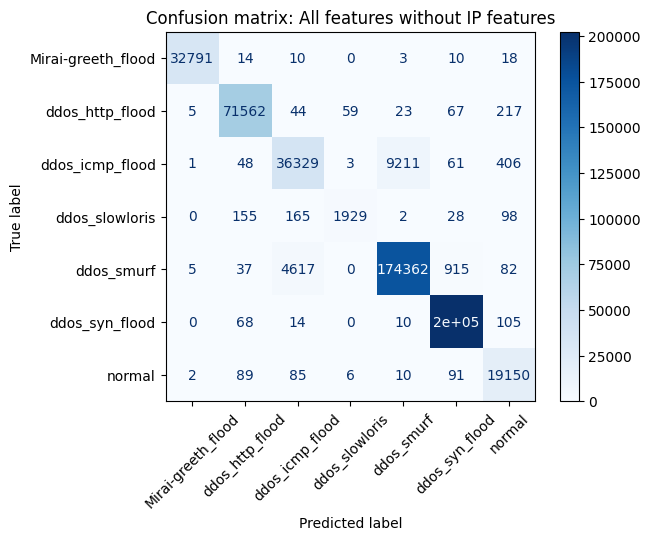

Test accuracy: 0.9697740255436857
Test precision: 0.9625627589748564
Test recall: 0.9351259592772028
Test f1-score: 0.9474755836637817
Test ROC-AUC: 0.997430539557916
Doing inference test...


  0%|          | 0/3 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count     3.000000
mean     11.068427
std       0.537378
min      10.537433
25%      10.796655
50%      11.055876
75%      11.333923
max      11.611970
dtype: float64


In [69]:
ip_features = filter_module(X_train.columns, 'ip')
train_xgboost(X_train.drop(columns=ip_features), y_train, X_test.drop(columns=ip_features), y_test, method_name='All features without IP features')

### 6.2 Use only UDP or TCP features

### 6.3 Mirai attack